## Signal processing and determination of the stimulus frequency

This notebook presents the signal processing and classification pipeline for the SSVEP detection, on the one subjects. All recorded data are available in the folder [data_collection\recorded_data](https://github.com/srete/ssvep-bci/tree/main/data_collection/recorded_data)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from signal_processing.preprocessing_functions import *
from signal_processing.cca import *

In [9]:
# Plot settings
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

#### I Data loading

In [10]:
fs = 200  # Hz, sampling frequency
session_name = 'S03_b'
data_folder = r'data_collection\recorded_data\{}'.format(session_name)
data_path = data_folder + '\\data.csv'
rec_info_path = r'data_collection\recorded_data\{}\recording_info.txt'.format(session_name)
with open(rec_info_path, 'r') as f:
    rec_info = f.read()

df = pd.read_csv(data_path)  # Dataframe
freqs, data = format_data(data_folder)  # Data formated as numpy array

# Shape of data: (n_blink_freqs, n_trial, n_chanels, n_samples)

# We want to remove the first second of data because of the board artefacts
time = data[0, :, -1, 1*fs:]
t = np.arange(0, len(time[0])/fs, 1/fs)
data = data[:, :, :-1, 1*fs:]

# Extracting electrode positions data from recording info txt file
EEG_CHN = {rec_info[rec_info.find(f'{i}:')+2 : rec_info.find(f'{i}:')+6].strip() : i for i in range(4)}
CHN_TO_POS = {v: k for k, v in EEG_CHN.items()}

# Data info
print('\n********** RECORDING INFO **********')
print(rec_info)

print('\n\n********** NUMPY ARRAY **********')
n_blink_freqs, n_trial, n_chanels, n_samples = data.shape
print('Data shape = (n_blink_freqs, n_trial, n_chanels, n_samples) = ', data.shape)

print('\n********** DATAFRAME **********')
df.head()




********** RECORDING INFO **********
Session name: S04
Date: 2023-05-30
Positions of EEG electrodes: 
	0: O1
	1: Oz
	2: O2
	3: POz
Target frequency: 12
Frequencies shown on screen: [7.5, 8.57, 10, 12]
Recording time: 21
	Recording started at: 10:41:40
	Recording ended at: 10:42:01

Additional information: 

All at once

zuta - 0
narandzasta - 1
braon - 2
crvena - 3
crna - REF
bela - D_G


********** NUMPY ARRAY **********
Data shape = (n_blink_freqs, n_trial, n_chanels, n_samples) =  (4, 1, 4, 4002)

********** DATAFRAME **********


,blink_freq,ch1,ch2,ch3,ch4,timestamp
0,10.0,-18.314290,-8.250219,-20.057083,-18.093636,1.685436e+09
1,10.0,2.902162,-0.067318,-1.428642,6.159615,1.685436e+09
2,10.0,-1.316445,-3.014359,-4.297145,2.056945,1.685436e+09
3,10.0,-16.926787,-4.487880,-23.299577,-15.647741,1.685436e+09
4,10.0,-15.591643,-6.944994,-25.532297,-13.250466,1.685436e+09


### II EEG signal filtering

EEG signal filtering consists of the following steps:
1. Removing the DC component, since each EEG channel has a different DC offset in the row data
2. Applying a notch filter at 50Hz to remove the power line noise
3. Applying a Chebyshev bandpass filter with parameters
    - passband from 6-32Hz to keep only the frequencies used as stimulus (7.5-30Hz)
    - filter order 4

We show the example of signal filtering on one subject on the first 5s of the recording.

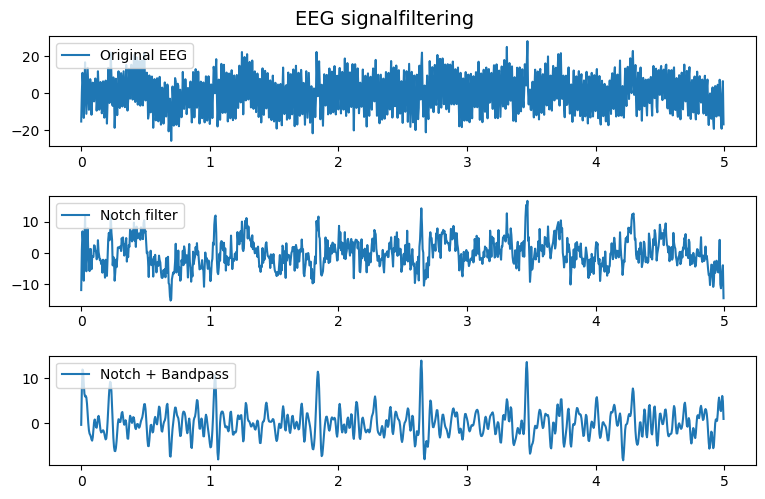

<Figure size 640x480 with 0 Axes>

In [11]:
# Removing DC offset
noisy_data = data[:, :, :, :5*fs]
ch_i = 0
trial_i = 0
freq_i = 0

t5 = t[:5*fs]
noisy_data = np.apply_along_axis(remove_dc_offset, -1, noisy_data)
# Notch filter
quality_factor = 20
notch_freq = 50.0  # Hz
data_notch = np.apply_along_axis(notch_filter, -1, noisy_data, fs, notch_freq, quality_factor)
# Chebyshev bandpass filter
low = 6  # Hz
high = 32  # Hz
order = 4
rp = 0.1
data_filtered = np.apply_along_axis(cheby_filter, -1, data_notch, fs, low, high, order, rp)

fig, axs = plt.subplots(3, 1, figsize=(8, 5))
plt.figure()
fig.tight_layout(pad=1.5)
axs[0].plot(t5, noisy_data[freq_i, trial_i, ch_i, :], label='Original EEG')
axs[0].legend(loc='upper left')
axs[1].plot(t5, data_notch[freq_i, trial_i, ch_i, :], label='Notch filter')
axs[1].legend(loc='upper left')
axs[2].plot(t5, data_filtered[freq_i, trial_i, ch_i, :], label='Notch + Bandpass')
axs[2].legend(loc='upper left')
# add title to figure
fig.suptitle(f'EEG signal filtering ', y=1)
plt.show()

### III EEG signal spectrum

We expect that there is a peak in the spectrum of the recorded signal at the frequency of the stimulus. Therefore, we applied the Fourier transform to the filtered signal (example for the first 5s of the recording) and show the graphs for all stimulus frequencies.

We don't expect to see a peak for every frequency with every channel, so we show the channels where the peak is clearly visible on a separate graph.

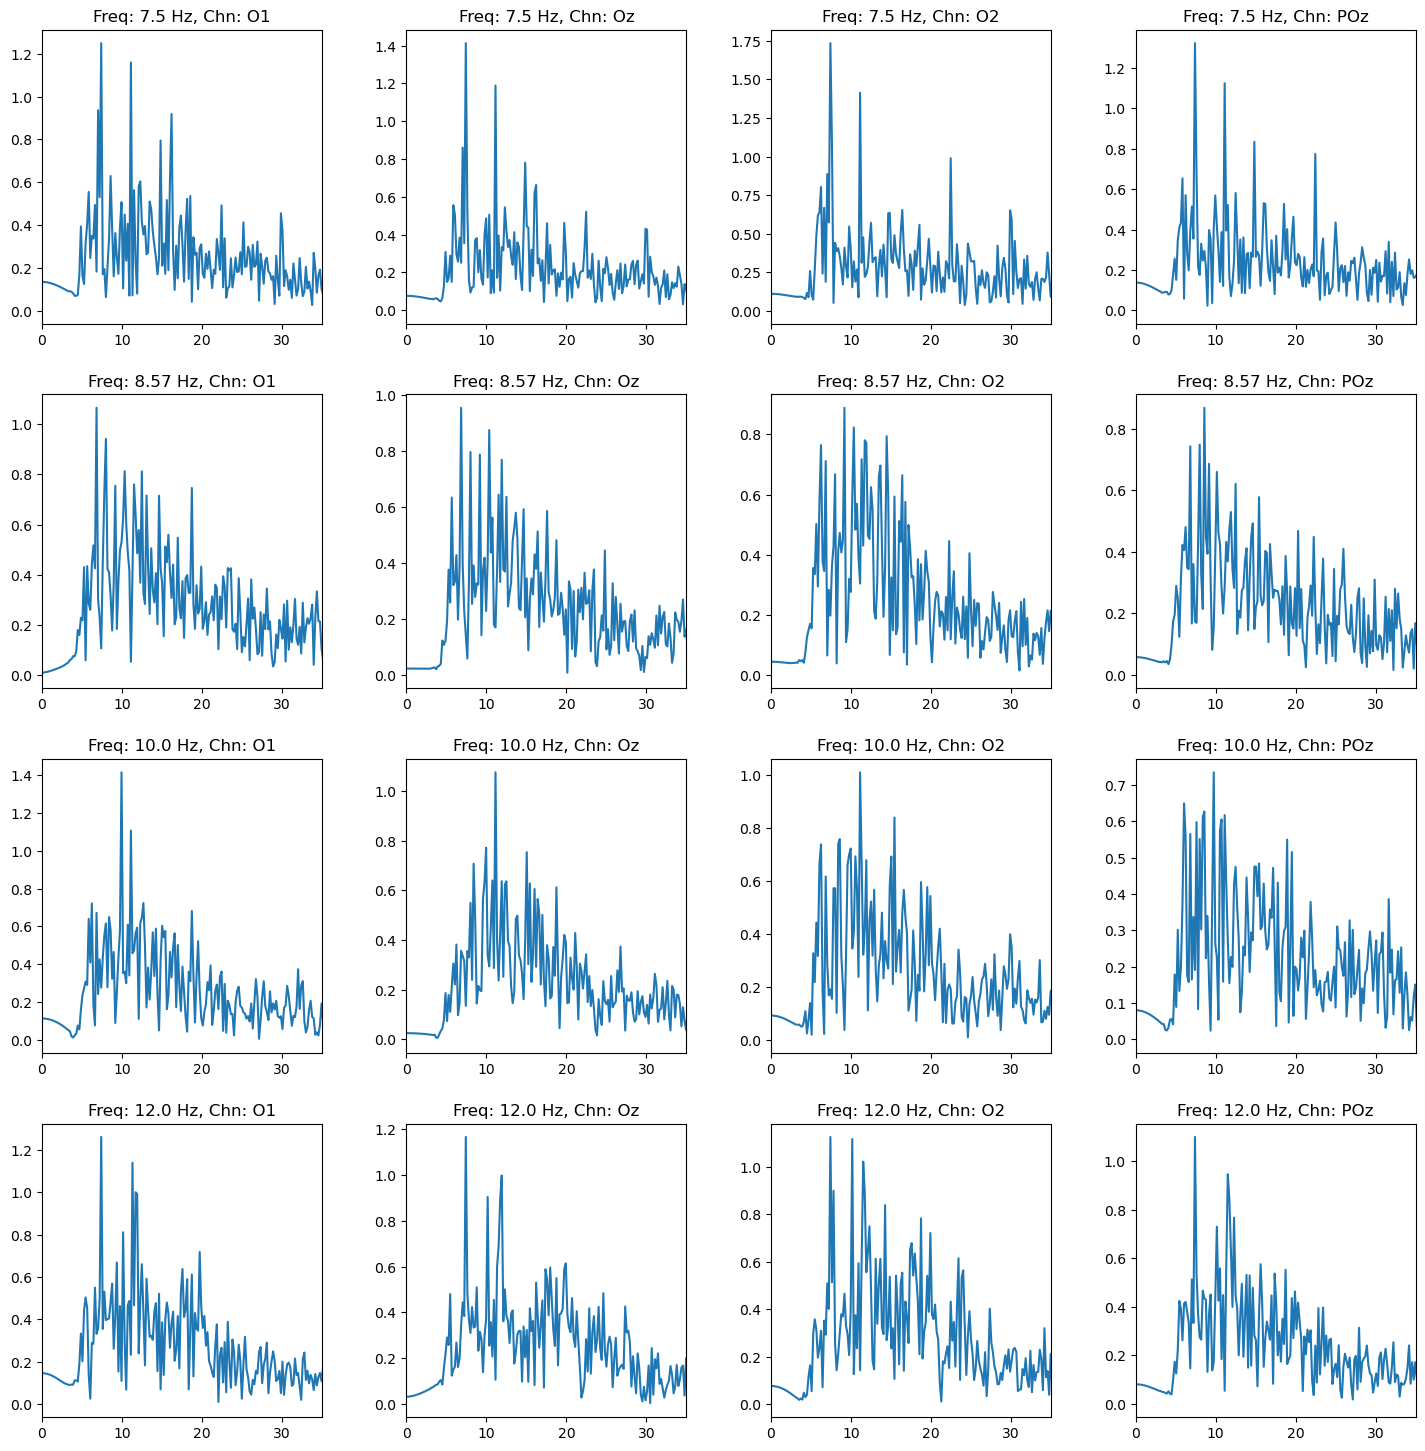

Electrode on postion O1 shows the cleares peak on the all stimulus frequency for this 


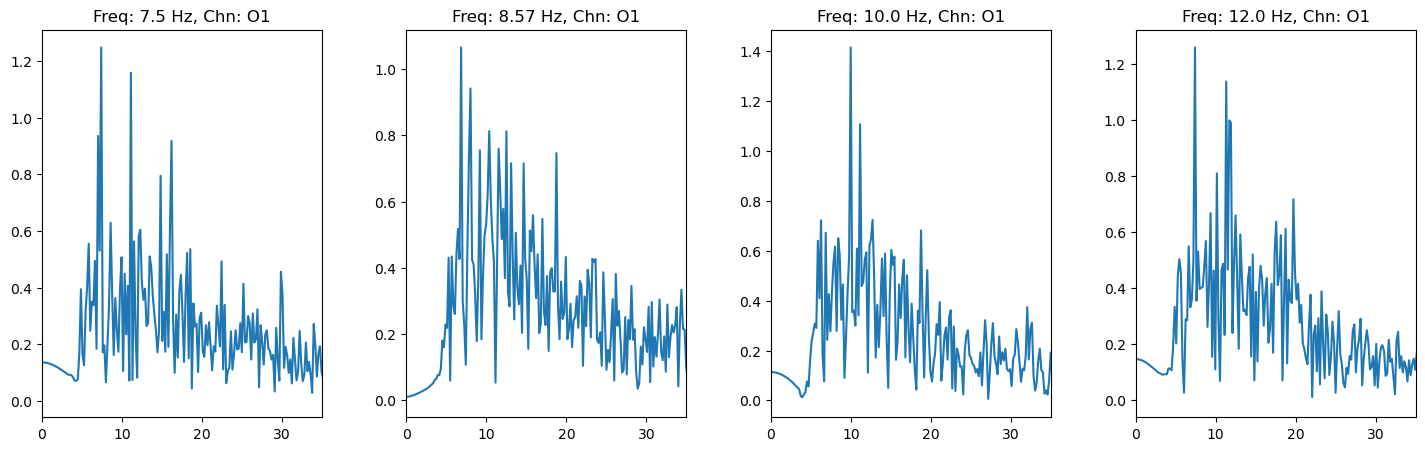

In [12]:
data_fft = np.apply_along_axis(signal_fft, -1, data_filtered, fs)
fft_fs = data_fft[0, 0, 0, 1, :]
data_fft = data_fft[:, :, :, 0, :]
plot_trial(0, data_fft, fft_fs, freqs, CHN_TO_POS)
print('Electrode on postion O1 shows the cleares peak on the all stimulus frequency for this ')

chn_to_plot = ['O1', 'O1', 'O1', 'O1']
fig, axs = plt.subplots(1, n_blink_freqs, figsize=(15, 5))
fig.tight_layout(pad=3.0)
for i in range(n_blink_freqs):
    axs[i].plot(fft_fs, data_fft[i, 0, EEG_CHN[chn_to_plot[i]], :])
    axs[i].set_title('Freq: ' + str(round(freqs[i], 2)) + ' Hz, Chn: ' + chn_to_plot[i])
    axs[i].set_xlim([0, 35])
plt.show()

### IV Canonical Correlation Analysis (CCA)

Canonical Correlation Analysis (CCA) is a method for determining the correlation between two multidimensional random variables. Let X be a matrix in which the samples of the filtered signal recorded for one stimulus frequency are stored, so that one row of the matrix corresponds to the recording from one channel. Let $Y_n$ be a matrix of reference signals corresponding to one stimulus frequency $f_n$, in whose rows the samples of the reference signals are stored. Since our reference signals are sinusoids, the matrix $Y_n$ is of the form

$$Y_{n} = \begin{bmatrix} \sin({2 \pi f_{n}t}) \\ \cos({2 \pi f_{n}t}) \\ \vdots \\ \sin({4 \pi  f_{n}t}) \\ \cos({4 \pi  f_{n}t}) \end{bmatrix},t = \begin{bmatrix} 
    \frac{1}{f_{s}}
    \frac{2}{f_{s}}
    \dots
    \frac{N_{s}}{f_{s}}
    \end{bmatrix}$$

where $f_s$ is the sampling frequency, $N_s$ is the number of samples and $N_h$ is the number of harmonics in the reference signal matrix. In our case, $N_h=1$.

The linear combinations of matrices X and Y are given by the equations

$ x=X^TW_x $ &nbsp;&nbsp;&nbsp; i &nbsp;&nbsp;&nbsp; $ y={Y_n}^TW_y $

CCA method finds weight matrices $W_x$ and $W_y$ that will maximize the correlation coefficient between random vectors x and y, by solving the system of equations.

$$\max_{W_{x},W_{y}} \rho_{n}(x,y) = \frac{\mathbb{E}{[W_{x}'XY'W_{y}]}}{\sqrt{\mathbb{E}{[W_{x}'XX'W_{x}]}\mathbb{E}{[W_{y}'YY'W_{y}]}}}$$

$\rho_n$ obtained in this way represents the correlation between the reference signal corresponding to the stimulus frequency $f_n$ and the signal from the channel where there is the greatest correlation with the reference signal.

We tested the CCA method with two types of the references. One where reference signals are sinusoids with the frequencies used as stimulus and the other where reference signals are sinusoids with all frequencies that could be shown on the monitor (60/n, where n is an integer >= 2). We show the results for both reference signals.

In [14]:
refresh_rate = 60 # Hz
target_freqs_1 = np.array([refresh_rate/i for i in range(2, 11)])  # 6-30 Hz
target_freqs_2 = freqs
ref = np.array([get_cca_reference_signals(data_filtered.shape[-1], f, fs) for f in target_freqs_1])

predictions, labels = cca_classify(data_filtered, ref)

print('\n'+'-'*20)
print('Labels\t\tPredictions')
print('-'*20)
for i in range(len(predictions)):
    print(f'{freqs[labels[i]] : .2f}\t\t{target_freqs_1[predictions[i]] : .2f}')
print('-'*20+'\n')



--------------------
Labels		Predictions
--------------------
 7.50		 7.50
 8.57		 8.57
 10.00		 10.00
 12.00		 12.00
--------------------

